In [43]:
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# The following code will mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [44]:
def plot_feature_trends(X, y, feature_names):
    # Create a DataFrame with features and genre labels
    data = pd.DataFrame(X, columns=feature_names)
    data['Genre'] = y

    # Calculate the average of each feature per genre
    feature_means = data.groupby('Genre').mean()

    # Plot each feature as a line plot across genres
    plt.figure(figsize=(12, 8))
    for feature in feature_means.columns:
        plt.plot(feature_means.index, feature_means[feature], marker='o', label=feature)

    plt.title('Feature Trends Across Genres')
    plt.xlabel('Genre')
    plt.ylabel('Average Feature Value')
    plt.xticks(rotation=45)
    plt.legend(title="Features", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [59]:
def plot_mel_spectrograms_by_genre(data_path, genres, sample_file='00000.wav', sr=22050):
    """Plot mel-spectrograms for one audio sample from each genre in a grid layout."""
    num_genres = len(genres)
    ncols = 5  # Number of columns for the grid
    nrows = (num_genres // ncols) + (num_genres % ncols > 0)  # Calculate rows based on number of genres
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))
    fig.suptitle("Mel-Spectrograms of Different Genres", fontsize=16)

    for i, genre in enumerate(genres):
        # Path to the sample file for each genre
        genre_path = os.path.join(data_path, genre, f"{genre}.{sample_file}")

        if os.path.isfile(genre_path):
            # Load the audio file
            y, sr = librosa.load(genre_path, sr=sr)
            # Generate mel-spectrogram
            mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

            # Plot mel-spectrogram in grid
            row, col = divmod(i, ncols)
            ax = axs[row, col]
            img = librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=ax, cmap='viridis')
            ax.set_title(f"{genre.capitalize()}", fontsize=10)
            #ax.axis('off')  # Hide axes for a cleaner look


    # Remove empty subplots if any genres are missing
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axs.flatten()[j])

    # Adjust layout and add a colorbar for the entire figure
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.colorbar(img, ax=axs, format='%+2.0f dB', orientation='vertical', fraction=0.02, pad=0.05)
    plt.show()

# List of genres you want to include in the visualization
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix for Genre Classification', fontsize=14)
    plt.xlabel('Predicted Genre', fontsize=12)
    plt.ylabel('True Genre', fontsize=12)
    plt.tight_layout()
    plt.show()

In [47]:
from sklearn.model_selection import cross_val_score

def plot_training_validation_curve(model, X_train, y_train):
    # Here, we're using cross-validation to plot training and validation curves
    train_scores = cross_val_score(model, X_train, y_train, cv=5)

    # Plot the training curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 6), train_scores, label='Training Accuracy', marker='o', color='b')
    plt.title('Training and Validation Curve', fontsize=14)
    plt.xlabel('Fold Number', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(range(1, 6))
    plt.legend()
    plt.tight_layout()
    plt.show()

In [48]:
def plot_genre_pie_chart(y):
    """Plot a pie chart of genre distribution."""
    genre_counts = pd.Series(y).value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(
        genre_counts,
        labels=genre_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette("pastel"),
    )
    plt.title("Proportional Distribution of Genres in Dataset")
    plt.tight_layout()
    plt.show()

In [49]:
def analyze_skip_factors(X, y, feature_names):
    """Analyze variance in features across genres, hinting at 'skip factors'."""
    df = pd.DataFrame(X, columns=feature_names)
    df['Genre'] = y
    genre_variance = df.groupby('Genre').var()

    plt.figure(figsize=(12, 8))
    sns.heatmap(genre_variance, annot=True, cmap="Reds", fmt=".2f")
    plt.title("Feature Variance by Genre (Potential Skip Factors)")
    plt.xlabel("Features")
    plt.ylabel("Genre")
    plt.show()


In [50]:
def extract_features(file_path):
    """Extract audio features from a file using librosa"""
    try:
        # Load audio file
        audio, sr = librosa.load(file_path, duration=30)

        # Extract features
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

        # Calculate statistics
        features = []
        for feature in [mfccs, spectral_centroid, chroma]:
            features.extend([
                np.mean(feature),
                np.std(feature),
                np.max(feature),
                np.min(feature)
            ])

        return features
    except Exception as e:
        print(f"Error extracting features from {file_path}: {str(e)}")
        return None

In [51]:
def process_data(data_path):
    features = []
    labels = []

    # Process each genre folder
    for genre in os.listdir(data_path):
        genre_path = os.path.join(data_path, genre)
        if os.path.isdir(genre_path):
            print(f"Processing {genre} files...")

            # Process each audio file in the genre folder
            for file_name in os.listdir(genre_path):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(genre_path, file_name)
                    extracted_features = extract_features(file_path)

                    if extracted_features:
                        features.append(extracted_features)
                        labels.append(genre)

    return np.array(features), np.array(labels)

In [52]:
def train_model(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Initialize and train the model
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)

    # Evaluate the model
    y_pred = clf.predict(X_test)
    print("\nModel Performance:")
    print(classification_report(y_test, y_pred))

    return clf, X_test, y_test

In [53]:
def predict_genre(model, file_path):
    """Predict the genre of a single audio file"""
    features = extract_features(file_path)
    if features:
        features = np.array(features).reshape(1, -1)
        prediction = model.predict(features)
        probabilities = model.predict_proba(features)

        # Get top 3 predictions with probabilities
        top_3 = np.argsort(probabilities[0])[-3:][::-1]
        genres = model.classes_[top_3]
        probs = probabilities[0][top_3]

        return list(zip(genres, probs))
    return None

Extracting features from audio files...
Processing pop files...
Processing rock files...
Processing classical files...
Processing disco files...
Processing reggae files...
Processing jazz files...
Error extracting features from /content/gdrive/My Drive/DS340W - Paper 1/Data/genres_original/jazz/jazz.00054.wav: 
Processing blues files...
Processing hiphop files...
Processing metal files...
Processing country files...


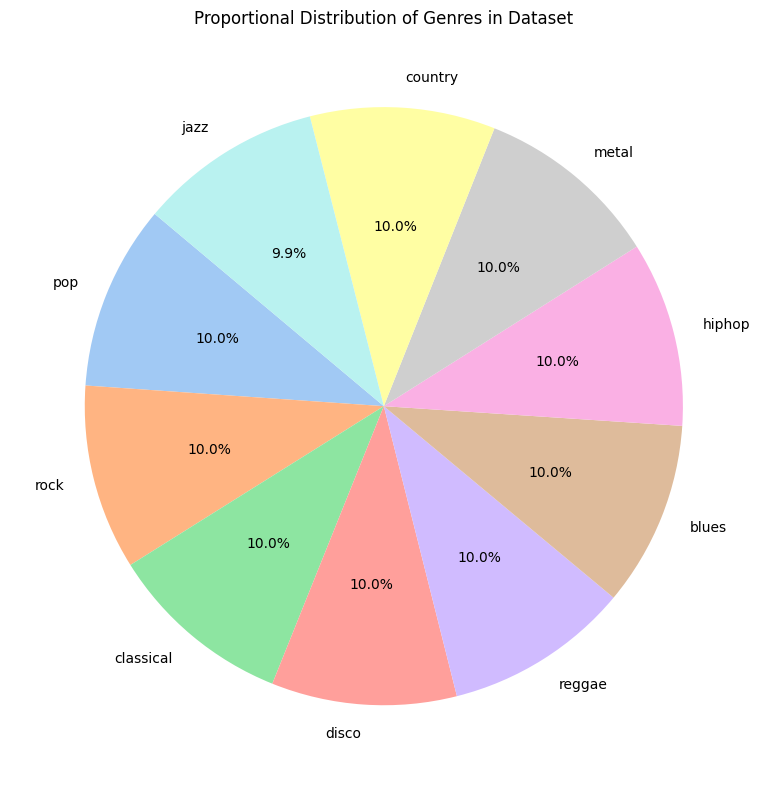

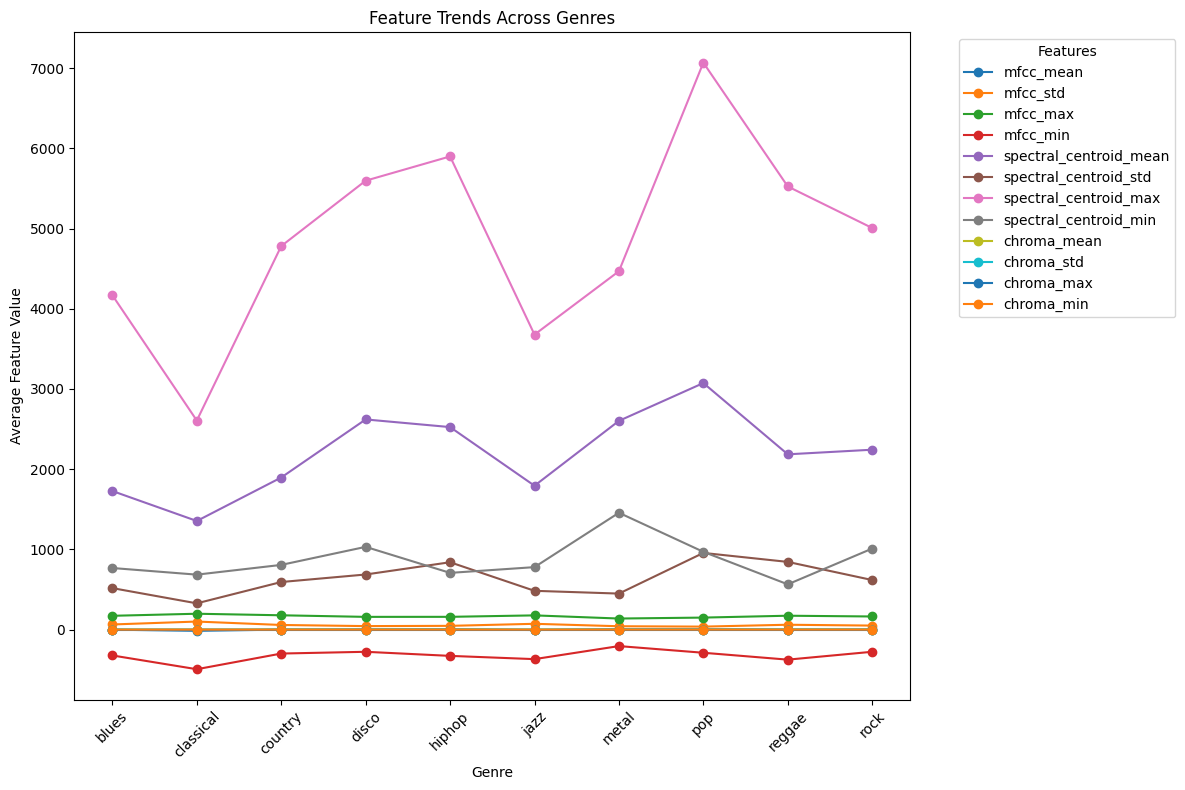

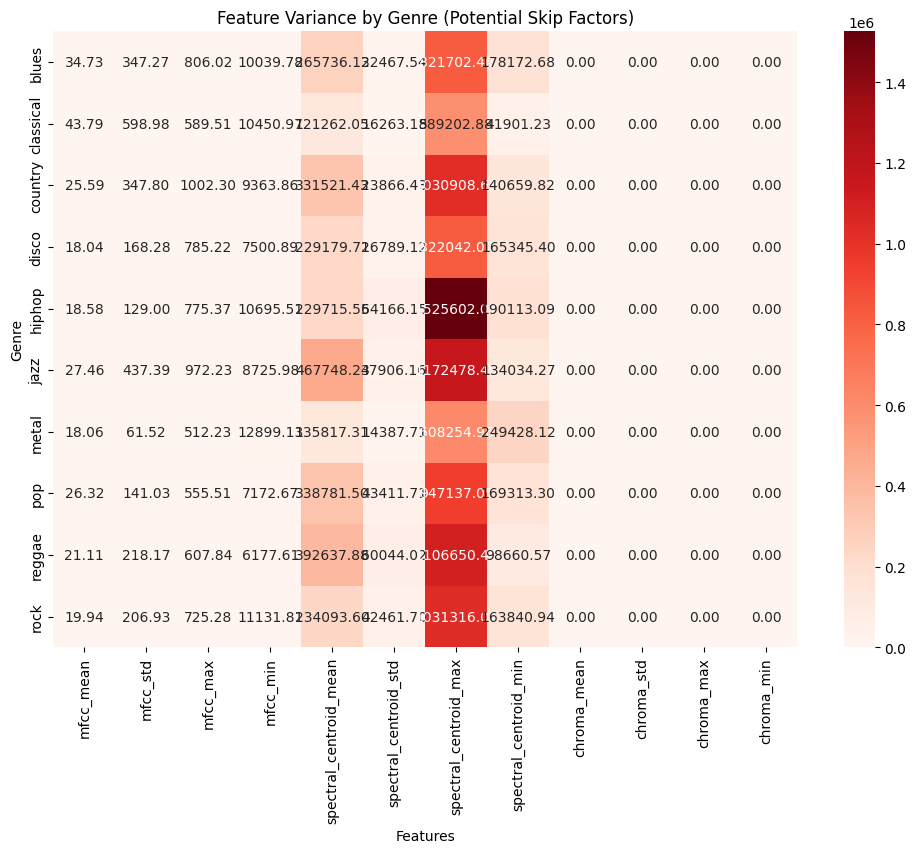


Training the model...

Model Performance:
              precision    recall  f1-score   support

       blues       0.60      0.50      0.55        18
   classical       0.88      0.88      0.88        24
     country       0.56      0.45      0.50        20
       disco       0.55      0.27      0.36        22
      hiphop       0.57      0.63      0.60        19
        jazz       0.72      0.67      0.69        27
       metal       0.74      0.91      0.82        22
         pop       0.70      0.76      0.73        21
      reggae       0.43      0.67      0.53        15
        rock       0.47      0.58      0.52        12

    accuracy                           0.64       200
   macro avg       0.62      0.63      0.62       200
weighted avg       0.64      0.64      0.63       200


Predicting genre for test file...

Top 3 predicted genres:
metal: 91.00%
blues: 5.00%
disco: 2.00%


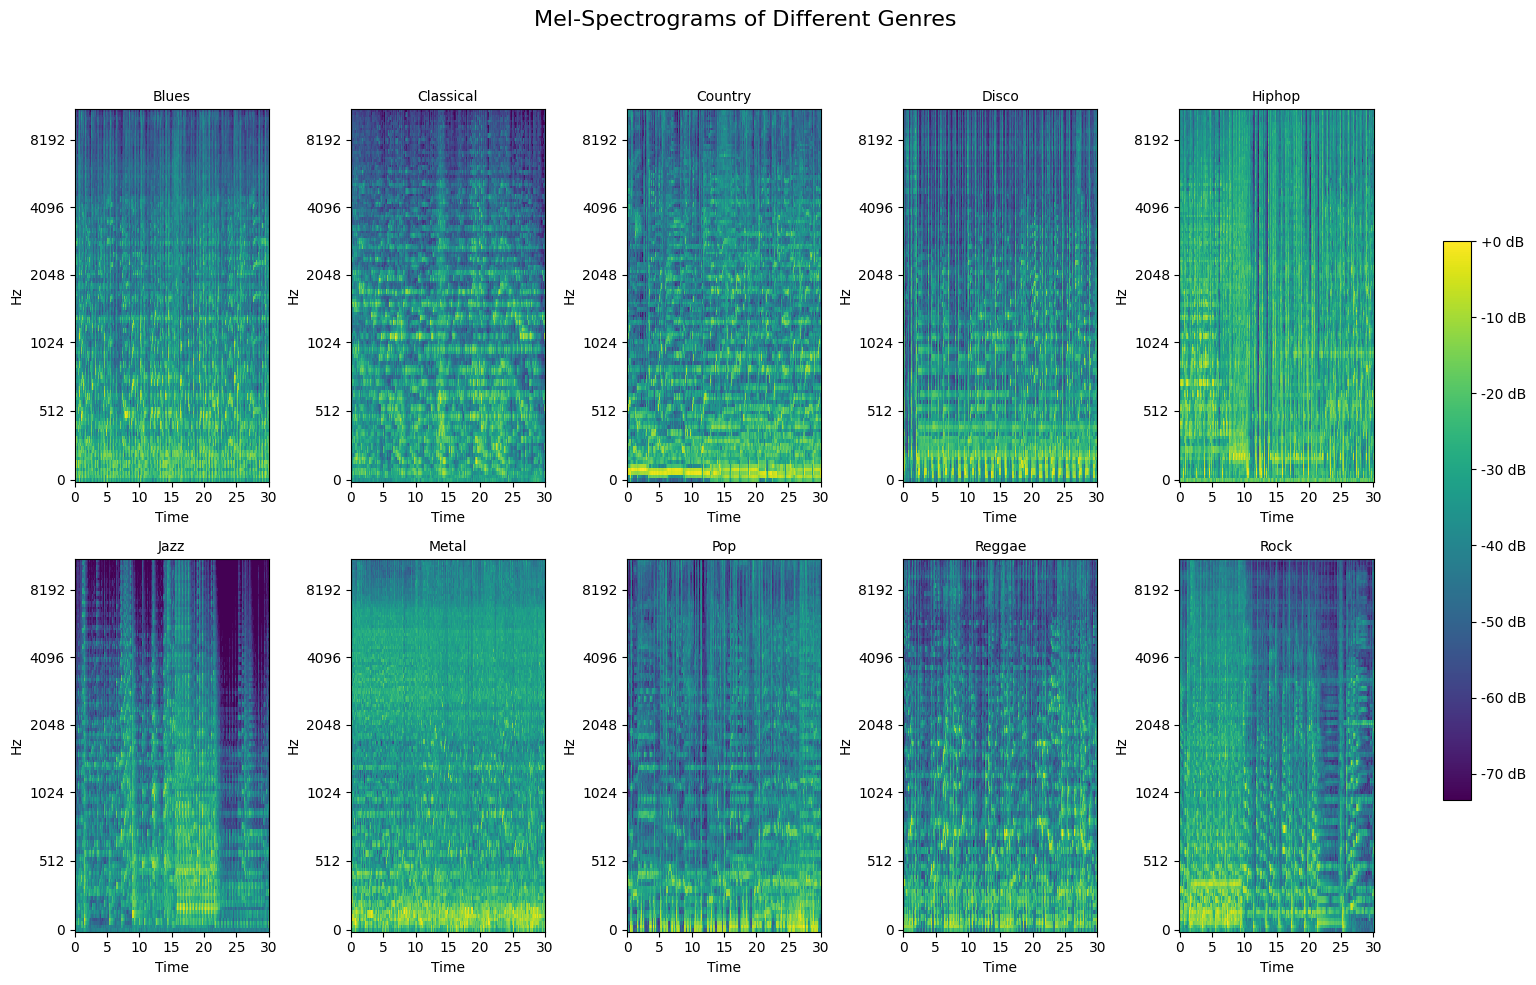

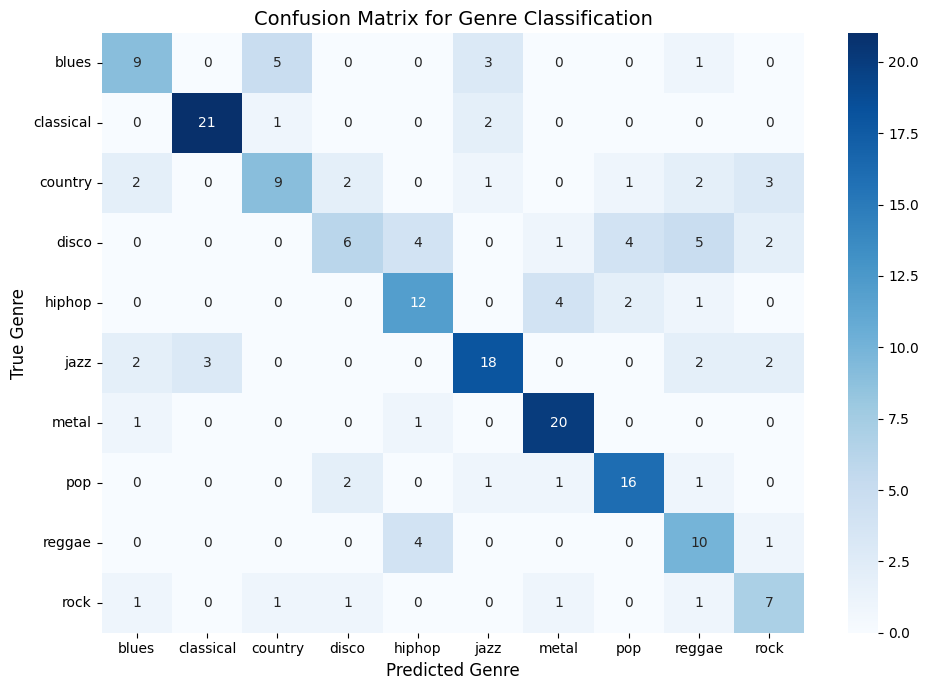

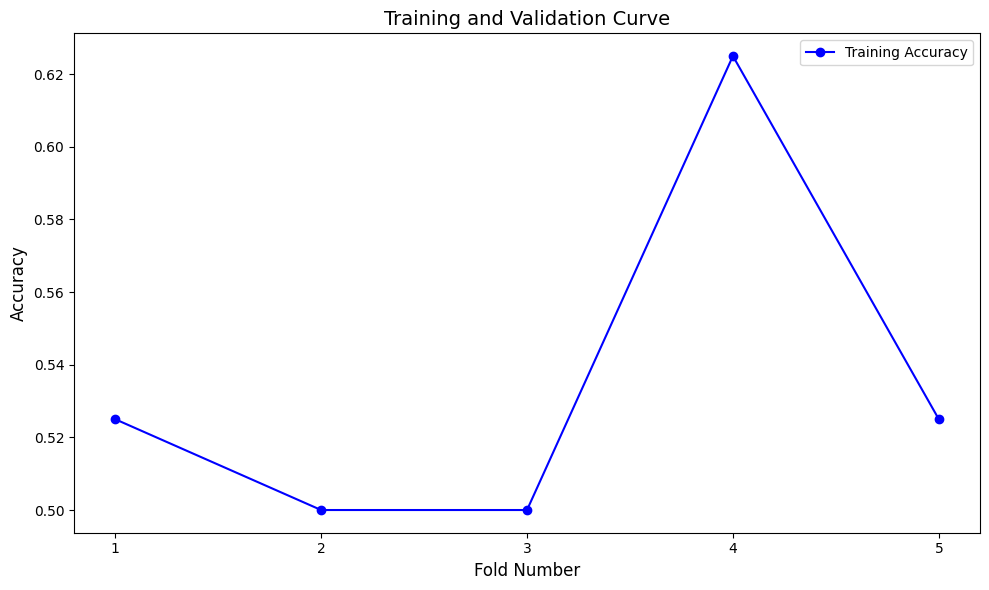

In [60]:
if __name__ == "__main__":
    # Replace with your dataset path
    DATA_PATH = '/content/gdrive/My Drive/DS340W - Paper 1/Data/genres_original'

    # Process all files
    print("Extracting features from audio files...")
    X, y = process_data(DATA_PATH)

    #Visualize the distribution of genres in the dataset and average feature values across genres
    feature_names = ['mfcc_mean', 'mfcc_std', 'mfcc_max', 'mfcc_min',
                 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_centroid_max', 'spectral_centroid_min',
                 'chroma_mean', 'chroma_std', 'chroma_max', 'chroma_min']

    #Observe Genre Distributions
    plot_genre_pie_chart(y)

    #Visualize feature trends
    plot_feature_trends(X, y, feature_names)

    #Analyze variance in features across genres, hinting at 'skip factors'
    analyze_skip_factors(X, y, feature_names)

    # Train the model
    print("\nTraining the model...")
    model, X_test, y_test = train_model(X, y)

    # Example prediction
    test_file = "/content/gdrive/My Drive/DS340W - Paper 1/Data/genres_original/metal/metal.00009.wav"
    print("\nPredicting genre for test file...")
    predictions = predict_genre(model, test_file)

    if predictions:
        print("\nTop 3 predicted genres:")
        for genre, prob in predictions:
            print(f"{genre}: {prob:.2%}")

    #Visualize sample mel-spectrogram
    plot_mel_spectrograms_by_genre(DATA_PATH, genres)

    #After training, visualize the confusion matrix
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, model.classes_)

    #After training, visualize training/validation curves
    plot_training_validation_curve(model, X_test, y_test)